# Chromosome Painting

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra
using DataFrames
using Plots
# using ProfileView

BLAS.set_num_threads(1)

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


# Download population data

Download [population code](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/) for each 1000 genomes sample. Different population code is explained [here](https://www.internationalgenome.org/category/population/). 

In [2]:
# run this code in terminal
# wget -r -l3 -N --no-parent ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/

# Get each sample's population origin

In [3]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/country_origin")
df = DataFrame(sample = String[], population = String[])
refID_to_population = Dict{String, String}()
for population in readdir("data/")
    for sample in readdir("data/" * population)
        sample == ".DS_Store" && continue
        push!(df, (sample, population))
        refID_to_population[sample] = population
    end
end
refID_to_population

Dict{String,String} with 2709 entries:
  "HG01791" => "GBR"
  "HG02736" => "PJL"
  "HG00182" => "FIN"
  "HG03914" => "BEB"
  "HG00149" => "GBR"
  "NA12156" => "CEU"
  "HG02642" => "GWD"
  "HG02851" => "GWD"
  "NA19835" => "ASW"
  "NA19019" => "LWK"
  "HG01131" => "CLM"
  "HG03725" => "ITU"
  "HG03578" => "MSL"
  "NA18550" => "CHB"
  "HG02401" => "CDX"
  "HG01350" => "CLM"
  "HG03973" => "ITU"
  "NA07000" => "CEU"
  "HG01709" => "IBS"
  "HG01395" => "PUR"
  "HG02388" => "CDX"
  "HG01980" => "PEL"
  "HG01979" => "PEL"
  "HG01122" => "CLM"
  "HG03869" => "ITU"
  ⋮         => ⋮

# Compute phase information

In [4]:
# compute each person's phase information
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.jlso"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, max_d=d,
    phase=true);

Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:09


Total windows = 2367, averaging ~ 527 unique haplotypes per window.

Timings: 
    Data import                     = 19.1125 seconds
        import target data             = 5.5513 seconds
        import compressed haplotypes   = 13.5612 seconds
    Computing haplotype pair        = 9.98981 seconds
        BLAS3 mul! to get M and N      = 0.329098 seconds per thread
        haplopair search               = 3.95338 seconds per thread
        initializing missing           = 0.0246123 seconds per thread
        allocating and viewing         = 0.0766396 seconds per thread
        index conversion               = 0.00176624 seconds per thread
    Phasing by win-win intersection = 0.722512 seconds
        Window-by-window intersection  = 0.0986906 seconds per thread
        Breakpoint search              = 0.0746708 seconds per thread
        Recording result               = 0.0114759 seconds per thread
    Imputation                     = 3.39241 seconds
        Imputing missing          

In [5]:
# check ultra-compression matches vcf.gz compression
X_answer = convert_gt(UInt8, "mendel.imputed.vcf.gz", trans=true)
X1, X2, _, _, H = convert_compressed(UInt8, outfile, "ref.chr18.excludeTarget.vcf.gz")
X_phased = X1 + X2
all(X_answer .== X_phased)

importing reference data...100%|████████████████████████| Time: 0:03:59


true

# Compute sample composition in 1000 genomes

In [6]:
# need compressed reference panel
reffile = "ref.chr18.maxd$d.maf$maf.excludeTarget.jlso"
compressed_Hunique = JLSO.load(reffile)[:compressed_Hunique]
panelID = compressed_Hunique.sampleID

# get sample's ancestry
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reader = VCF.Reader(openvcf(tgtfile, "r"))
tgtID  = VCF.header(reader).sampleID
sample_population = [refID_to_population[id] for id in tgtID];

In [7]:
findall(x -> x == "CHS", sample_population)

8-element Array{Int64,1}:
  4
  5
  6
  7
  8
  9
 10
 11

  0.000490 seconds (8 allocations: 1.250 KiB)
  0.000554 seconds (8 allocations: 1.250 KiB)
  0.000638 seconds (8 allocations: 1.250 KiB)


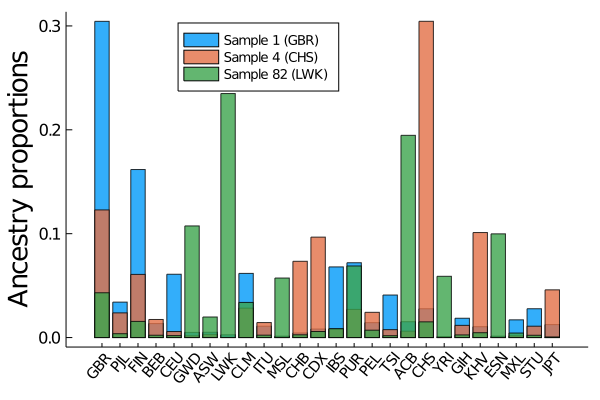

In [62]:
populations = unique_populations(refID_to_population)
@time sample1_comp = composition(ph[1], panelID, refID_to_population)
@time sample4_comp = composition(ph[4], panelID, refID_to_population)
@time sample82_comp = composition(ph[82], panelID, refID_to_population)

barplot = bar(sample1_comp, xticks=(1:1:26, populations), xrotation=50, grid=false, 
    ylabel = "Ancestry proportions", label="Sample 1 (GBR)", alpha=0.8, legend=:top,
    xtickfont=font(10), ytickfont=font(11), legendfont=font(9), yguidefontsize=18)
bar!(barplot, sample4_comp, label="Sample 4 (CHS)", alpha=0.8)
bar!(barplot, sample82_comp, label="Sample 82 (LWK)", alpha=0.8)

# Try painting an actual chromosome

Generated colors here: https://mdigi.tools/color-shades/#008000.

Colors are arranged such that:
+ Blue ≈ European/American
+ Red ≈ Asian
+ Green ≈ African

In [9]:
populations = unique_populations(refID_to_population)
@time sample1_s1_comp, sample1_s2_comp = paint(ph[1], panelID, refID_to_population)
@time sample4_s1_comp, sample4_s2_comp = paint(ph[4], panelID, refID_to_population)
@time sample82_s1_comp, sample82_s2_comp = paint(ph[82], panelID, refID_to_population);

  0.000380 seconds (12 allocations: 25.125 KiB)
  0.000262 seconds (12 allocations: 30.000 KiB)
  0.000466 seconds (12 allocations: 36.125 KiB)


In [10]:
# generated here: https://mdigi.tools/color-shades/#008000
# Blue ≈ European/American, Red ≈ Asian, Green ≈ Africa
goodcolors = [colorant"#e3e3ff", colorant"#ffe5e5", colorant"#ffb3b3", colorant"#aaaaff",
            colorant"#7171ff", colorant"#92ff92", colorant"#49ff49", colorant"#dbffdb", 
            colorant"#3939ff", colorant"#ff8080", colorant"#00ff00", colorant"#ff4d4d",
            colorant"#ff1a1a", colorant"#0000ff", colorant"#0000c6", colorant"#00008e", 
            colorant"#000055", colorant"#00b600", colorant"#e60000", colorant"#006d00", 
            colorant"#b30000", colorant"#800000", colorant"#002400", colorant"#00001c",
            colorant"#4d0000", colorant"#1a0000"]

In [11]:
sample1_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample1_s1_comp[2]]
sample1_s1_colors = reshape(sample1_s1_colors, 1, length(sample1_s1_colors))

sample1_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample1_s2_comp[2]]
sample1_s2_colors = reshape(sample1_s2_colors, 1, length(sample1_s2_colors))

sample4_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample4_s1_comp[2]]
sample4_s1_colors = reshape(sample4_s1_colors, 1, length(sample4_s1_colors))

sample4_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample4_s2_comp[2]]
sample4_s2_colors = reshape(sample4_s2_colors, 1, length(sample4_s2_colors))

sample82_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample82_s1_comp[2]]
sample82_s1_colors = reshape(sample82_s1_colors, 1, length(sample82_s1_colors))

sample82_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample82_s2_comp[2]]
sample82_s2_colors = reshape(sample82_s2_colors, 1, length(sample82_s2_colors));

In [54]:
using StatsPlots, FixedPointNumbers

sample1_s1l = length(sample1_s1_comp[1])
sample1_s2l = length(sample1_s2_comp[1])
sample4_s1l = length(sample4_s1_comp[1])
sample4_s2l = length(sample4_s2_comp[1])
sample82_s1l = length(sample82_s1_comp[1])
sample82_s2l = length(sample82_s2_comp[1])
maxlen = max(sample1_s1l, sample1_s2l, sample4_s1l, sample4_s2l, sample82_s1l, sample82_s2l)

# mylabels = reshape(populations, 1, 26)
mydata = zeros(6, maxlen)
copyto!(@view(mydata[1, 1:sample1_s1l]), sample1_s1_comp[1])
copyto!(@view(mydata[2, 1:sample1_s2l]), sample1_s2_comp[1])
copyto!(@view(mydata[3, 1:sample4_s1l]), sample4_s1_comp[1])
copyto!(@view(mydata[4, 1:sample4_s2l]), sample4_s2_comp[1])
copyto!(@view(mydata[5, 1:sample82_s1l]), sample82_s1_comp[1])
copyto!(@view(mydata[6, 1:sample82_s2l]), sample82_s2_comp[1])

mycolors = Matrix{RGB{Normed{UInt8,8}}}(undef, 6, maxlen)
copyto!(@view(mycolors[1, 1:sample1_s1l]), sample1_s1_colors)
copyto!(@view(mycolors[2, 1:sample1_s2l]), sample1_s2_colors)
copyto!(@view(mycolors[3, 1:sample4_s1l]), sample4_s1_colors)
copyto!(@view(mycolors[4, 1:sample4_s2l]), sample4_s2_colors)
copyto!(@view(mycolors[5, 1:sample82_s1l]), sample82_s1_colors)
copyto!(@view(mycolors[6, 1:sample82_s2l]), sample82_s2_colors)

xnames = ["Sample 1 hap1", "Sample 1 hap2", "Sample 4 hap1", "Sample 4 hap2", 
        "Sample 82 hap1", "Sample 82 hap2"]
ynames = ["SNP 1", "SNP 212k", "SNP 426k", "SNP 639k", "SNP 852k"]

chrom_plt = groupedbar(mydata, bar_position = :stack, bar_width=0.7, label=:none, 
    lw = 0, color=mycolors, xticks=(1:1:6, xnames), yticks=(0:0.25:1, ynames),
    ytickfont=font(12), xtickfont=font(12), xrotation=20)

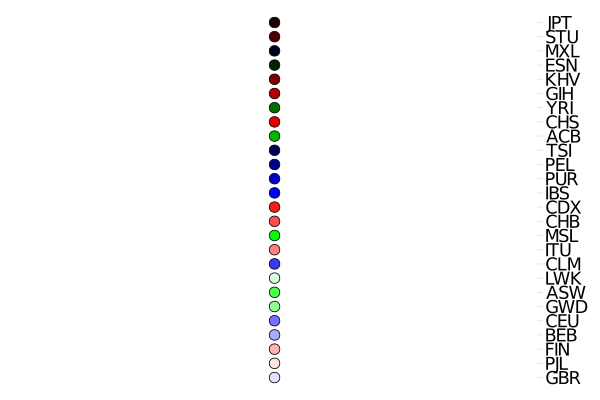

In [55]:
# create a plot for legend. 
color_x = ones(26)
color_y = collect(1:1:26)
mylegend = scatter(color_x, color_y, color=goodcolors, ytick=(1:1:26, populations), 
    xrange=(0.9, 1.1), xtick=false, label=:none, markersize=6, ytickfont=font(12),
    grid=false, framestyle=:grid, mirror=true, tick_direction=:out)

In [56]:
# combine chromosome painting with legend
chrom_plt_with_legend = plot(chrom_plt, mylegend, layout = grid(1, 2, widths=[0.95, 0.05]))

# Combined all plots

In [ ]:
final_plt = plot(barplot, chrom_plt_with_legend, size=(1300, 600), 
    layout = grid(1, 2, widths=[0.5, 0.50]), left_margin = 5Plots.mm)

fontsize=24
annotate!(final_plt, -5.0,  0.31 , text("A", :left, fontsize), subplot=1)
annotate!(final_plt, -1.5,  1.01 , text("B", :left, fontsize), subplot=2)

In [71]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/country_origin")
savefig(final_plt, "admixture.png") # remember to set dpi=300